In [2]:
include("TYUtils.jl")
using CairoMakie
using FourierFlows
using FourierFlows: parsevalsum2
using JLD2
using Printf
using LinearAlgebra: ldiv!
using AbstractFFTs
using .TYUtils: decompose_balanced_wave, compute_balanced_basis, compute_wave_bases

In [2]:
t2 = zeros(251)
en2 = zeros(251)
grid = TwoDGrid(; nx=512, Lx=6π)
for i=1:251
    #println(i)
    base_file = jldopen(@sprintf("/vast/nad9961/thomasyamada_simulation/47679600/ty.jld2.%08d.jld2", i))
    key = keys(base_file["snapshots/t"])[end]
    t2[i] = base_file["snapshots/t/" * key]
    snap = base_file["snapshots/sol/" * key]
    energy = parsevalsum2(snap[:,:,2], grid) + parsevalsum2(snap[:,:,3], grid) + parsevalsum2(snap[:,:,4], grid)
    energy += parsevalsum2(sqrt.(grid.invKrsq) .* snap[:,:,1], grid)
    en2[i] = energy
    close(base_file)
end

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /ext3/pkgs/packages/JLD2/MYcfT/src/JLD2.jl:298


LoadError: SystemError: opening file "/vast/nad9961/thomasyamada_simulation/47679600/ty.jld2.00000001.jld2": No such file or directory

In [29]:
function get_vars(solution, grid)
    ζt = Array{Float64}(undef, (grid.nx, grid.ny))
    qc = Array{Float64}(undef, (grid.nx, grid.ny))
    ucy = Array{Float64}(undef, (grid.nx, grid.ny))
    vcx = Array{Float64}(undef, (grid.nx, grid.ny))
    pc = Array{Float64}(undef, (grid.nx, grid.ny))
    
    ζth = deepcopy(solution[:,:,1])
    uch = deepcopy(solution[:,:,2])
    vch = deepcopy(solution[:,:,3])
    pch = deepcopy(solution[:,:,4])
    
    ldiv!(ζt, grid.rfftplan, ζth)
    ldiv!(ucy, grid.rfftplan, im * grid.l  .* uch)
    ldiv!(vcx, grid.rfftplan, im * grid.kr .* vch)
    ldiv!(pc, grid.rfftplan, pch)
    
    qc = vcx - ucy - pc
    return (ζt, qc)
end

diagnostic_file = jldopen("/scratch/nad9961/thomasyamada_simulation/50380476/diagnostics.jld2")
data_file = jldopen(@sprintf("/scratch/nad9961/thomasyamada_simulation/50380476/ty.jld2.%08d.jld2", 251))
t = diagnostic_file["diagnostics/baroclinic_energy/t"]
en = diagnostic_file["diagnostics/baroclinic_energy/data"] + diagnostic_file["diagnostics/barotropic_energy/data"]
close(diagnostic_file)

fig = Figure(size=(1200,1000), fontsize=32)
axζ = Axis(fig[1:2,1][1,1]; title="Barotropic vorticity", aspect=1)
axq = Axis(fig[1:2,2][1,1]; title="Baroclinic PV", aspect=1)
#axE = Axis(fig[3,1:2]; title="Total energy", xlabel="t", ylabel="Energy")
#axKEspec = Axis(fig[2,1:2];
#        xlabel = "Radial wavenumber",
#        ylabel = "Energy density",
#        xscale = log10,
#        yscale = log10,
#        title = "Radial energy spectrum")

grid = TwoDGrid(CPU(); nx=512, Lx=6π, aliased_fraction=0, T=Float64)

ζt, qc = get_vars(data_file["snapshots/sol/25108"], grid)

ζcolorrange = (-maximum(abs.(ζt)), maximum(abs.(ζt)))
qcolorrange = (-maximum(abs.(qc)), maximum(abs.(qc)))
ζhm = heatmap!(axζ, grid.x, grid.y, ζt; colormap = :balance, colorrange=ζcolorrange)
qhm = heatmap!(axq, grid.x, grid.y, qc; colormap = :balance, colorrange=qcolorrange)

lines!(axE, t, en, label="Spin-up time")
lines!(axE, t2, en2, color="red", label="Time-series analysis")
axislegend(axE)

fig

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /ext3/pkgs/packages/JLD2/MYcfT/src/JLD2.jl:298


LoadError: SystemError: opening file "/scratch/nad9961/thomasyamada_simulation/50380476/diagnostics.jld2": No such file or directory

In [26]:
data_file["snapshots/sol"]

JLD2.Group
 ├─🔢 25100
 ├─🔢 25101
 ├─🔢 25102
 ├─🔢 25103
 ├─🔢 25104
 ├─🔢 25105
 ├─🔢 25106
 ├─🔢 25107
 ├─🔢 25108
 └─ ⋯ (26 more entries)

18.333333333333332
["k", "t", "ut_series", "vt_series", "ug_series", "vg_series", "uw_series", "vw_series", "ut", "vt", "ug", "vg", "uw", "vw", "U_balanced", "U_wave", "U_total"]
(40100, 512)


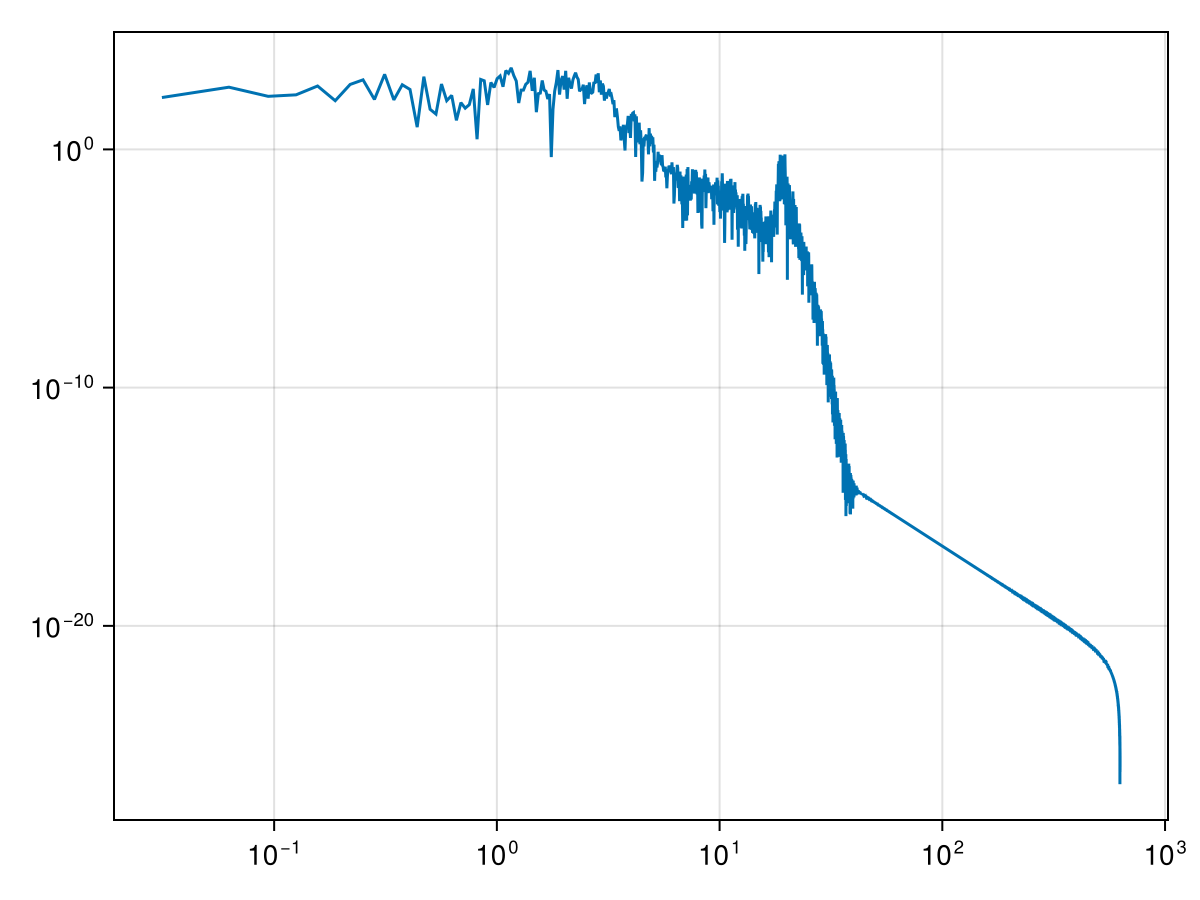

In [4]:
function hann(L)
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. 0.5 * (1 - cos.(2*π*n/N))
    return w[1:end-1]
end

function flattopw(L)
    a0 = 0.21557895
    a1 = 0.41663158
    a2 = 0.277263158
    a3 = 0.083578947
    a4 = 0.006947368
    ell = L+1
    
    n = 0:(ell - 1)
    w = @. (a0 - a1*cos(2*π*n/(ell - 1))
              + a2*cos(4*π*n/(ell - 1))
              - a3*cos(6*π*n/(ell - 1))
              + a4*cos(8*π*n/(ell - 1)))
    return w[1:end-1]
end

initial_data_file = jldopen("/scratch/projects/shaferlab/nick/thomasyamada_fourier/sm-waves-sm-Ro/56/radial_data_k=056.jld2")
println(initial_data_file["k"])
N = length(initial_data_file["t"])
N_half = Int((N)//2)
t = initial_data_file["t"]
dt = t[2] - t[1]
println(keys(initial_data_file))
println(size(initial_data_file["vg"]))
vc = fft(ifft(initial_data_file["vg"], 1), 1)
test_spec = fft(hann(N) .* initial_data_file["uw_series"])
close(initial_data_file)
ω = fftshift(fftfreq(N, 1/dt)) * 2*pi
lines(-ω[1:N_half], abs2.(fftshift(test_spec, 1)[1:N_half,12]), axis=(; xscale=log10, yscale=log10))

In [5]:
grid = TwoDGrid(CPU(); nx=512, Lx=6π, aliased_fraction=0, T=Float64)
initial_data_file

JLDFile /scratch/projects/shaferlab/nick/thomasyamada_fourier/sm-waves-sm-Ro/56/radial_data_k=056.jld2 (read-only)
  (closed)

In [10]:
window = hann(N)
initial_data_file = jldopen("/scratch/nad9961/thomasyamada_fourier/50380476/1/radial_data_k=001.jld2")
UT = fft(window .* initial_data_file["U_total"])
close(initial_data_file)
lines!(abs2.(UT)[:,1])
UT

29700×512 Matrix{ComplexF64}:
  1.53793-3.11354im  1.92115-3.13964im  …  0.966361-3.04902im
  2.08505-3.13913im  2.27547-3.17447im      1.70783-3.08009im
   2.0714-3.13845im   2.2785-3.17035im        1.674-3.07925im
  2.05528-3.13764im  2.28086-3.1658im       1.63953-3.07814im
  2.03665-3.1367im   2.28247-3.16082im      1.60485-3.07675im
   2.0155-3.1356im   2.28325-3.15543im  …   1.57046-3.07507im
  1.99186-3.13433im  2.28307-3.14964im      1.53689-3.07309im
  1.96581-3.13285im  2.28183-3.14348im       1.5047-3.07078im
  1.93749-3.13114im  2.27939-3.13696im      1.47448-3.06815im
  1.90709-3.12918im  2.27563-3.13009im       1.4468-3.06519im
  1.87488-3.12695im  2.27043-3.12289im  …   1.42224-3.0619im
  1.84119-3.12441im  2.26368-3.11538im      1.40132-3.05828im
  1.80639-3.12156im  2.25531-3.10755im      1.38454-3.05433im
         ⋮                              ⋱  
 0.741135-3.17247im  1.65814-3.13737im     0.160586-3.17072im
 0.762098-3.16919im  1.65742-3.13523im     0.154282-3.16102

In [11]:
println((Sys.total_memory() - Sys.free_memory()) / 2^20, " GB used")

153015.14453125 GB used


In [8]:
function demean(data)
    mean = sum(data, dims=1) / size(data, 1)
    return data .- mean
end

function linear_least_squares(t, data)
    tsum = sum(t)
    t2sum = sum(t.^2)
    txsum = sum(t .* data, dims=1)
    N = size(t,1)
    slope = (N * (txsum)) / (N * t2sum - tsum.^2)
    intercept = -slope * tsum / N
    return (slope, intercept)
end

function detrend(t, data)
    m, b = linear_least_squares(t, demean(data))
    return data .- m .* t .- b
end

detrend (generic function with 1 method)

In [22]:
grid = TwoDGrid(; Lx=6π, nx=512)

k_max = 256
max_radial_K = grid.kr[end] * sqrt(2)
max_effective_radial_K = grid.kr[k_max]
refinement_factor = 4
dk = grid.kr[2] - grid.kr[1]
k_values = (0:(max_radial_K * refinement_factor)) ./ refinement_factor .+ dk/2

#ut_data = zeros(N)
#vt_data = zeros(N)
U_data = zeros(N, ceil(Int, max_radial_K * refinement_factor))
#vc_data = zeros(N, ceil(Int, max_radial_K * refinement_factor))
#uc2_data = zeros(N, ceil(Int, max_radial_K * refinement_factor))
#vc2_data = zeros(N, ceil(Int, max_radial_K * refinement_factor))
#rotary_data = zeros(N, ceil(Int, max_radial_K * refinement_factor))
energy_data = zeros(N, ceil(Int, max_radial_K * refinement_factor))
for k_idx=1:k_max
    data_file = nothing
    filename = nothing
    filename = @sprintf("/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/%d/radial_data_k=%03d.jld2", k_idx, k_idx)
    
    if !isfile(filename) 
        println("Missing file: " * filename)
        continue
    end
    println(filename)
    data_file = jldopen(filename)
    radial_k = sqrt.(data_file["k"]^2 .+ grid.l[1:end].^2)
    radial_index = floor.(Int, radial_k * refinement_factor) .+ 1
    radial_index2 = round.(Int, radial_k * refinement_factor) .+ 1
    N = length(data_file["t"])
    window = hann(N)
    N_half = Int((N)//2)
    t = data_file["t"]
    dt = t[2] - t[1]
    ω = fftshift(fftfreq(N, 1/dt)) * 2*pi
    #uw_data += sum(abs2.(fftshift(data_file["uw"], 1)), dims=2)
    #vw_data += sum(abs2.(fftshift(data_file["vw"], 1)), dims=2)
    U_series = (data_file["ug_series"] + data_file["uw_series"] + data_file["ut_series"]) + 
           1im*(data_file["vg_series"] + data_file["vw_series"] + data_file["vt_series"])
    U_series = detrend(t, U_series)
    temp_U = fftshift(fft(window .* U_series, 1), 1)
    #temp_vc = fftshift(data_file["vc"], 1)
    for r_idx=1:length(radial_index)
        if k_values[radial_index[r_idx]] <= max_effective_radial_K
            U_data[:,radial_index[r_idx]] += abs2.(temp_U[:,r_idx])
            #vc_data[:,radial_index[r_idx]] += abs2.(temp_vc[:,r_idx])
        end
        #if k_values[radial_index2[r_idx]] <= max_effective_radial_K
        #    uc2_data[:,radial_index2[r_idx]] += abs2.(temp_uc[:,r_idx])
        #    vc2_data[:,radial_index2[r_idx]] += abs2.(temp_vc[:,r_idx])
        #end
    end
    #uc_data += sum(abs2.(fftshift(data_file["uc"], 1)), dims=2)
    #vc_data += sum(abs2.(fftshift(data_file["vc"], 1)), dims=2)
    #ut_data += sum(abs2.(fftshift(data_file["ut"], 1)), dims=2)
    #vt_data += sum(abs2.(fftshift(data_file["vt"], 1)), dims=2)
    #rotary_data += sum(abs2.(fftshift(data_file["radial_rotary"], 1)), dims=2)
    #energy_data += sum(abs.(fftshift(data_file["radial_energy"], 1)), dims=2)
    close(data_file)
    data_file = nothing
    GC.gc()
end

/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/1/radial_data_k=001.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/2/radial_data_k=002.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/3/radial_data_k=003.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/4/radial_data_k=004.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/5/radial_data_k=005.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/6/radial_data_k=006.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/7/radial_data_k=007.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/8/radial_data_k=008.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/9/radial_data_k=009.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/10/radial_data_k=010.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/11/radial_data_k=011.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/12/radial_data_k=012.jld2
/scratch/nad9961/thomasyamada_fourier/sm-Ro-no-waves/13/radia

In [25]:
max_radial_K = grid.kr[k_max]
k_values = (0:(k_max * refinement_factor)) ./ refinement_factor .+ dk/2
println(length(k_values))
println(size(U_data))
#contourf(k_values, ω[N_half+2:end], log.(uc_data[N_half+2:end,:]'), levels=40)
println(max_effective_radial_K * refinement_factor)

1025
(40100, 483)
340.0


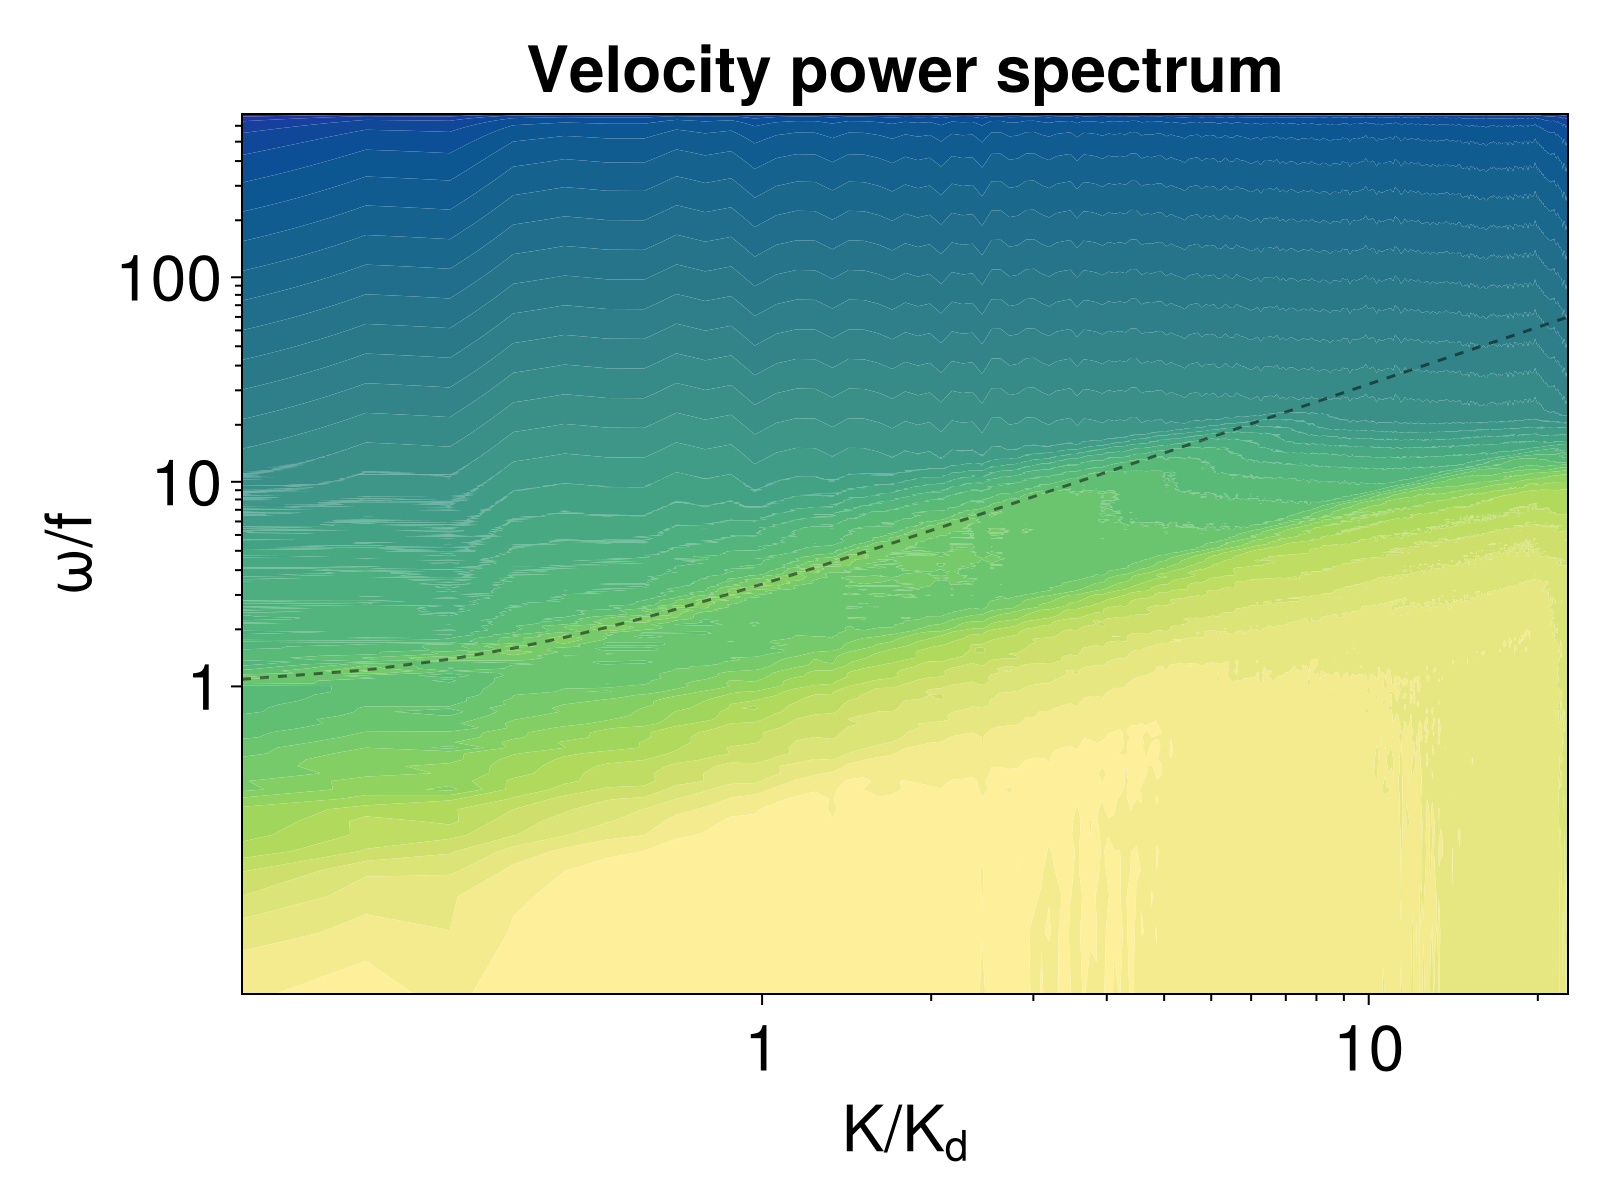

In [26]:
K_max = 256
K_d = 3

scaled_U_data = U_data * grid.dx / grid.nx
f = Figure(size=(800, 600), fontsize=32)
ax = Axis(f[1,1], title="Velocity power spectrum", 
    xlabel=rich("K/K", subscript("d")), ylabel="ω/f", 
    xscale=log10, yscale=log10,
    xticks = [1, 10], yticks=[1, 10, 100],
    xminorticks=IntervalsBetween(10), yminorticks=IntervalsBetween(10),
    xminorticksvisible = true, yminorticksvisible = true)

cmap = cgrad(:viridis, scale=log10)
x_data = k_values[2:K_max]/K_d
#z_data = uc_data[N_half+2:end,2:K_max]' + vc_data[N_half+2:end,2:K_max]' + uc_data[N_half:-1:1,2:K_max]' + vc_data[N_half:-1:1,2:K_max]'
z_data = scaled_U_data[N_half+2:end, 2:K_max]'
hm = contourf!(ax, x_data, ω[N_half+2:end], log.(z_data), levels=40, colormap=:haline)
lines!(ax, x_data, sqrt.(1 .+ (K_d*x_data).^2), linestyle=:dash, color="black", alpha=0.5)

#lines!(ax, x_data, 0 * x_data .+ 0.06, color="blue", linewidth=1, linestyle=:dash)
#lines!(ax, x_data, 0 * x_data .+ 0.83, color="blue", linewidth=1, linestyle=:dash)
#lines!(ax, x_data, 0 * x_data .+ 1.11, color="red", linewidth=1, linestyle=:dash)
#lines!(ax, x_data, 0 * x_data .+ 5., color="red", linewidth=1, linestyle=:dash)
#lines!(ax, x_data, 0 * x_data .+ 8.05, color="green", linewidth=1, linestyle=:dash)
#lines!(ax, x_data, 0 * x_data .+ 627.96, color="green", linewidth=1, linestyle=:dash)

#cb = Colorbar(f[1,2], hm)

f

In [33]:
ω

-628.3185307042438:0.031337582578765275:628.287193121665

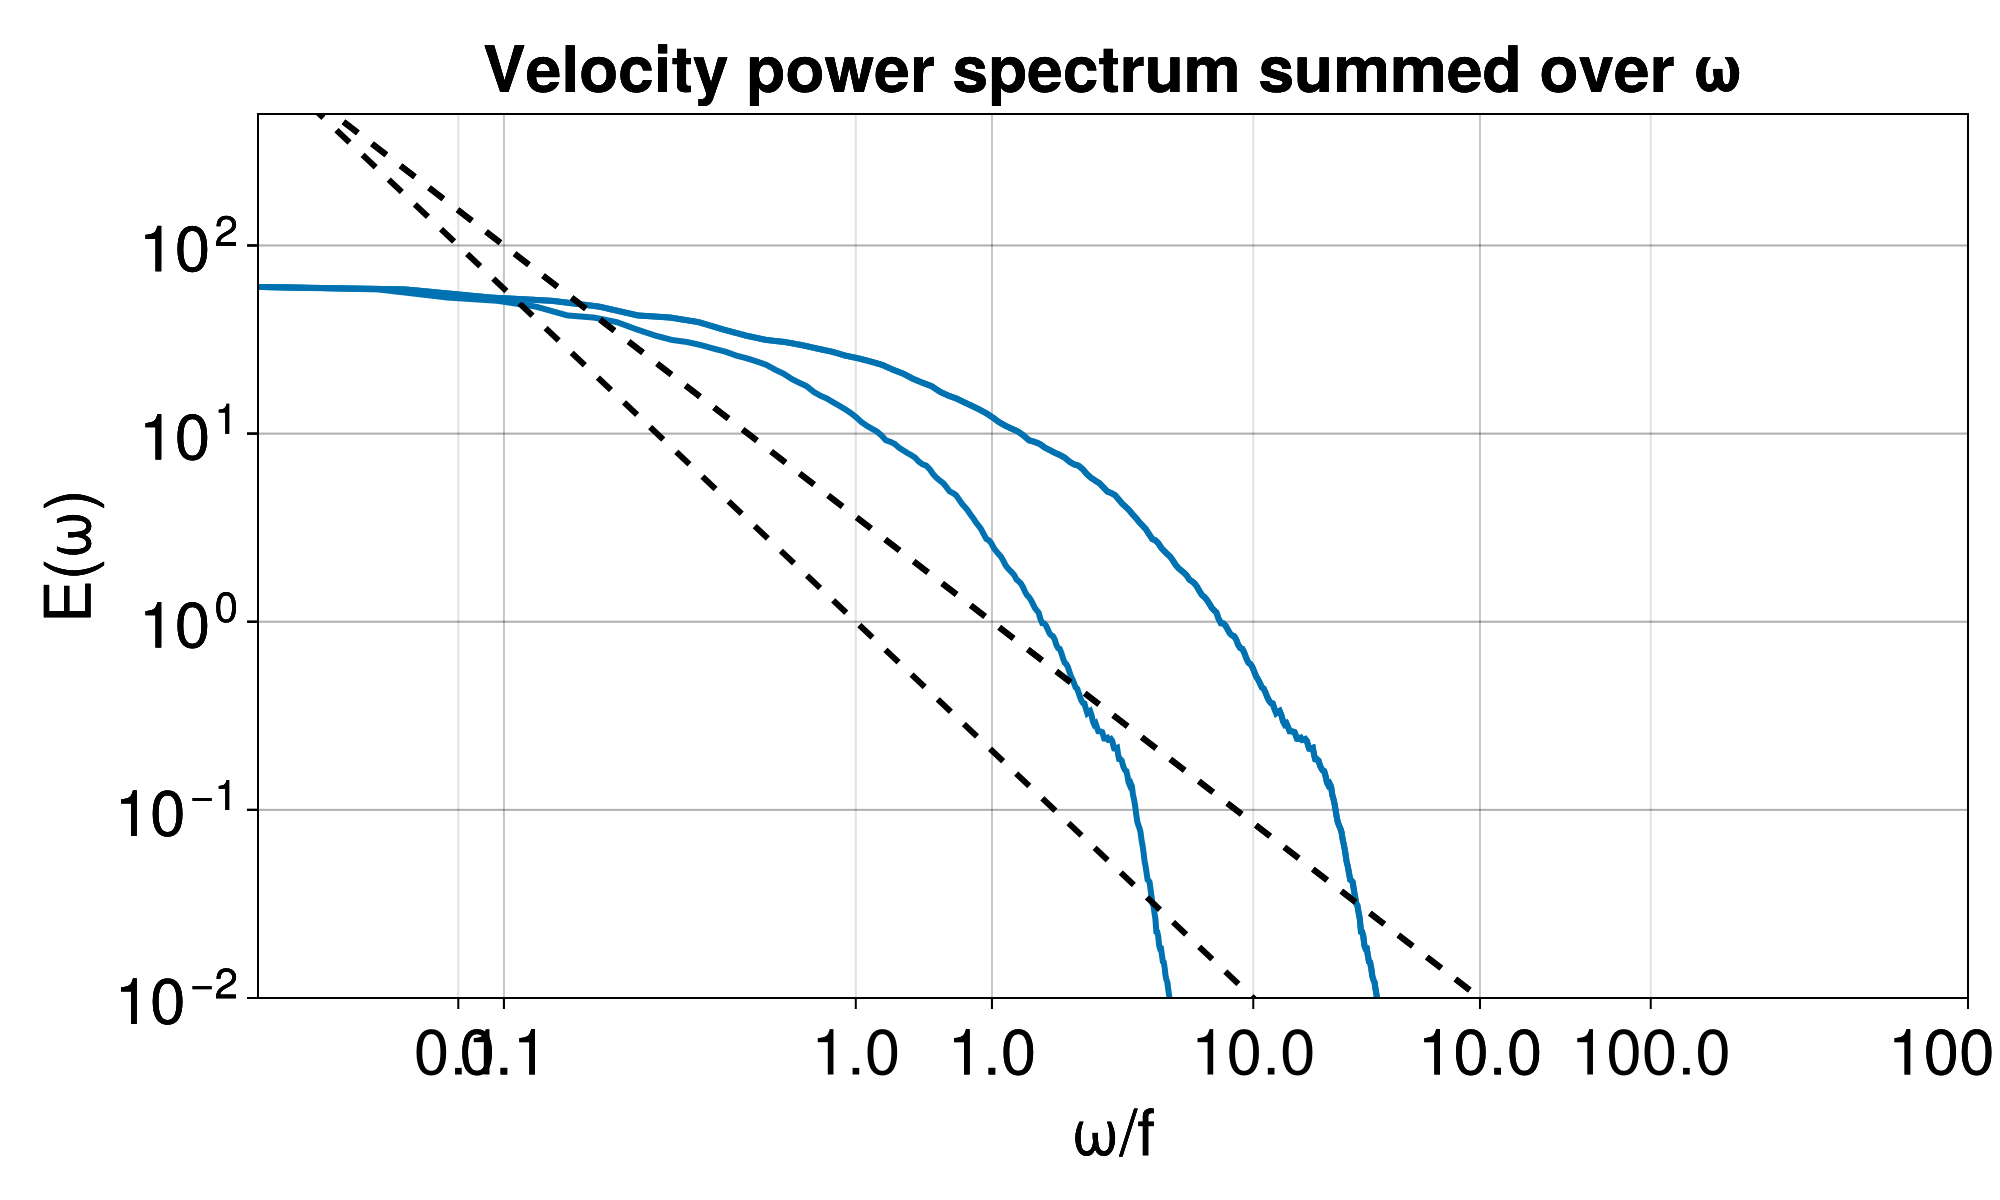

In [40]:
## f = Figure(size=(1000, 600), fontsize=32)
ax = Axis(f[1,1], title="Velocity power spectrum summed over ω", 
    xlabel="ω/f", ylabel="E(ω)",
    xscale=log10, yscale=log10,
    limits=((ω[N_half+2], 100), (1e-2, 5e2)),
    xticks = [0.1, 1, 10, 100])

#cmap = cgrad(:viridis, scale=log10)
bc_data = sum(scaled_U_data[N_half:-1:2,:], dims=2)[:] + 
        #sum(vc_data[N_half:-1:1,:], dims=2)[:] + 
        sum(scaled_U_data[N_half+2:end,:], dims=2)[:]
        #sum(vc_data[N_half+2:end,:], dims=2)[:]
bc_data *= dt / N / grid.nk / grid.nl
#bw_data = sum(uw_data[N_half:-1:1,:], dims=2)[:] + 
#        sum(vw_data[N_half:-1:1,:], dims=2)[:] + 
#        sum(uw_data[N_half+2:end,:], dims=2)[:] + 
#        sum(vw_data[N_half+2:end,:], dims=2)[:]

lines!(ax, ω[N_half+2:end], bc_data, label="total velocity", linewidth=3)
#lines!(ax, ω[N_half+2:end], bw_data/2e8, label="wave components", linewidth=3)
pos_ω = ω[N_half+2:end]
lines!(ax, pos_ω, pos_ω.^(-2.00), label=L"ω^{-2.00}", linestyle=:dash, color="black", linewidth=3)
#hm = contourf!(ax, k_centers, -ω[1:N_half], log.(rotary_v[1:N_half,:]'), levels=40)
#lines!(ax, k_centers, sqrt.(1 .+ k_centers.^2), linestyle=:dash, color="black")
#contour!(ax, k_centers, ω[N_half+2:end],  rotary_v[N_half+2:end,:]')
#cb = Colorbar(f[1,2], hm)
#axislegend(ax)
f

In [38]:
sum(bc_data)/1.9330812087960776e7

2.0106840575196293e8

1 1992
0.050195209163506664 99.98885665371309


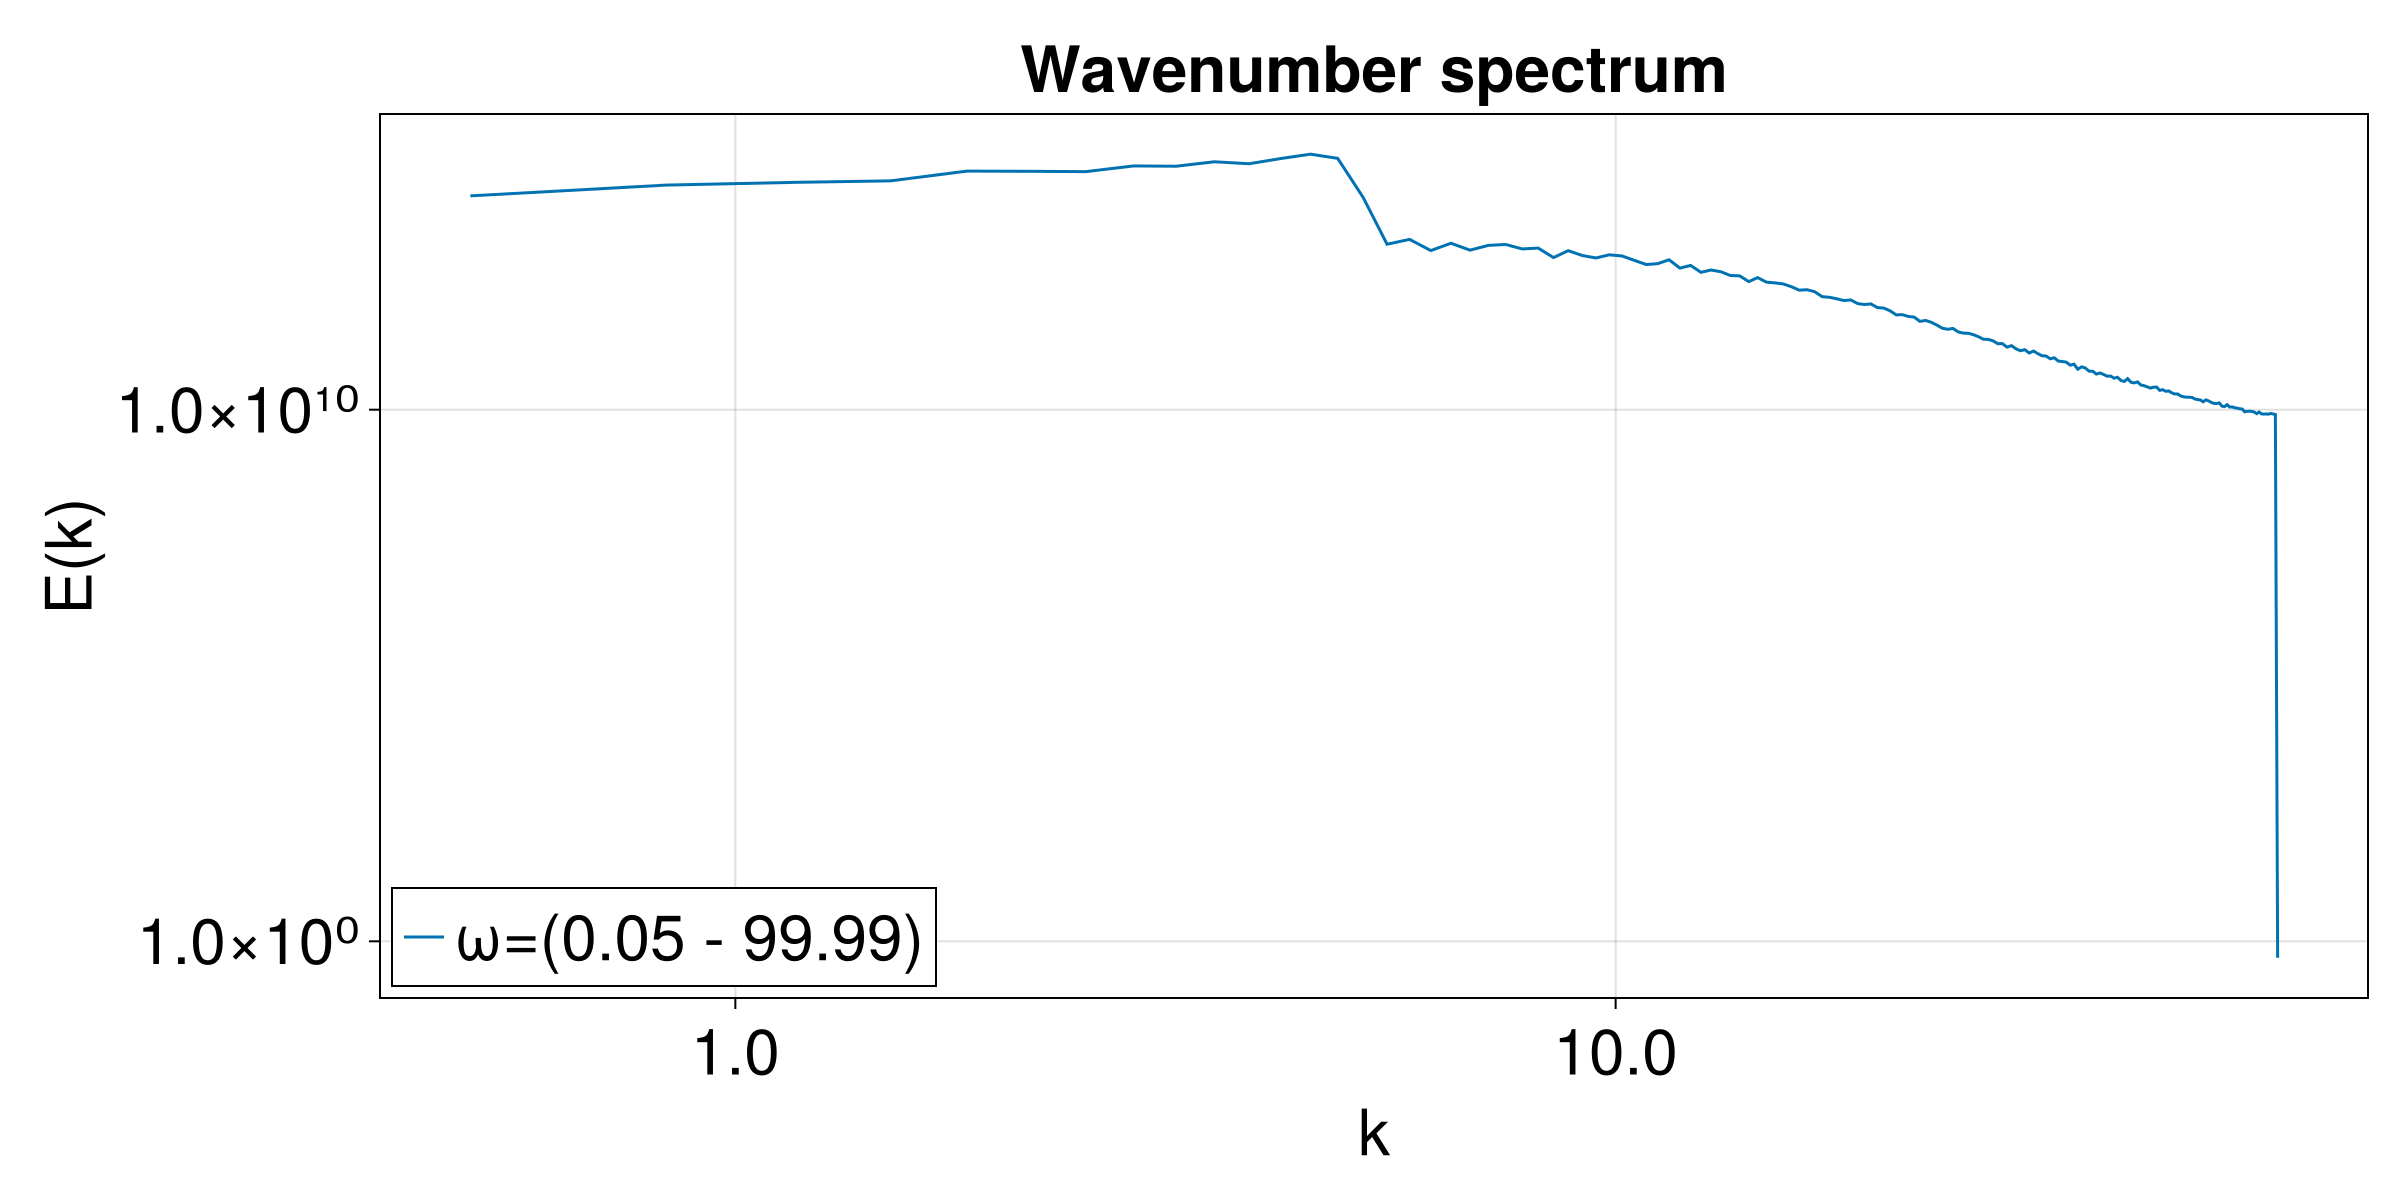

In [32]:
f = Figure(size=(1200, 600), fontsize=32)
ω_ranges = [[-1,100]]
ω_values = ω[N_half+2:end]
trend_multiplier = [1e10, 1e13, 5e9]

ax = Axis(f[1,1], title="Wavenumber spectrum", 
        xlabel="k", ylabel="E(k)",
        yticks=[1, 1e10],
        xticks=[1e-1, 1, 10],
        xscale=log10, yscale=Makie.pseudolog10)
for idx=1:length(ω_ranges)
    ω_range = ω_ranges[idx]
    ω_min_idx = findfirst(ω -> ω > ω_range[1], ω_values)
    ω_max_idx = findfirst(ω -> ω > ω_range[2], ω_values) - 1
    println(ω_min_idx, " ", ω_max_idx)
    println(ω_values[ω_min_idx], " ", ω_values[ω_max_idx])


    y_data = sum(uc_data[(N_half+1-ω_min_idx):-1:(N_half+1-ω_max_idx),2:K_max], dims=1)[:] + 
             sum(vc_data[(N_half+1-ω_min_idx):-1:(N_half+1-ω_max_idx),2:K_max], dims=1)[:] + 
             sum(uc_data[(N_half+1+ω_min_idx):(N_half+1+ω_max_idx),2:K_max], dims=1)[:] + 
             sum(vc_data[(N_half+1+ω_min_idx):(N_half+1+ω_max_idx),2:K_max], dims=1)[:]

    #pos_ω = ω_values[ω_min_idx:ω_max_idx]
    lines!(ax, k_values[2:K_max], y_data, label=@sprintf("ω=(%.2f - %.2f)", ω_values[ω_min_idx], ω_values[ω_max_idx]))
    #lines!(ax, pos_ω, trend_multiplier[idx]*pos_ω.^(-2.00), label=L"ω^{-2.00}", linestyle=:dash, color="black")
end
axislegend(ax, position=:lb)
#hm = contourf!(ax, k_centers, -ω[1:N_half], log.(rotary_v[1:N_half,:]'), levels=40)
#lines!(ax, k_centers, sqrt.(1 .+ k_centers.^2), linestyle=:dash, color="black")
#contour!(ax, k_centers, ω[N_half+2:end],  rotary_v[N_half+2:end,:]')
#cb = Colorbar(f[1,2], hm)

f

In [94]:
ω_range = ω_ranges[3]
ω_min_idx = findfirst(ω -> ω > ω_range[1], ω_values)
ω_max_idx = findfirst(ω -> ω > ω_range[2], ω_values) - 1
println(ω_values[ω_min_idx])
println(ω_values[ω_max_idx])
ω[(N_half+1+ω_min_idx):(N_half+1+ω_max_idx)]
ω[(N_half+1-ω_min_idx):-1:(N_half+1-ω_max_idx)]

8.050027563869232
627.9576674132732


-8.050027563869183:-0.05551743147496005:-627.957667413273

In [51]:
x = [4, 5, 6, 7, 8]
println(findfirst(y -> y > 6, x))

4


In [19]:
grid = TwoDGrid(; Lx=6π, nx=512)
grid.nkr

257

In [130]:
initial_data_file = jldopen("/scratch/nad9961/thomasyamada_fourier/47587522/radial_data_k=001.jld2")
N = length(data_file["t"])
t = data_file["t"]
dt = t[2] - t[1]
close(initial_data_file)

N_half = Int((N-1)//2)
max_k = 60
k_centers = zeros(max_k)
rotary_v = zeros(N, max_k)
energy = zeros(N, max_k)

grid = TwoDGrid(; Lx=6π, nx=512)
dk = grid.kr[2] - grid.kr[1]

ω = fftshift(fftfreq(N, 1/dt)) * 2*pi

dt = base_file["snapshots/t/2"] - base_file["snapshots/t/1"]
for k_idx = 1:max_k
    data_file = jldopen(@sprintf("/scratch/nad9961/thomasyamada_fourier/47545732/radial_data_k=%03d.jld2", k_idx))
    k_filter =  data_file["k"]
    k_centers[k_idx] = sqrt(minimum(grid.Krsq[k_filter])) + dk/2
    rotary_v[:,k_idx] = fftshift(data_file["radial_rotary"])
    energy[:,k_idx] = fftshift(data_file["radial_energy"])
end

0.055517431474984995


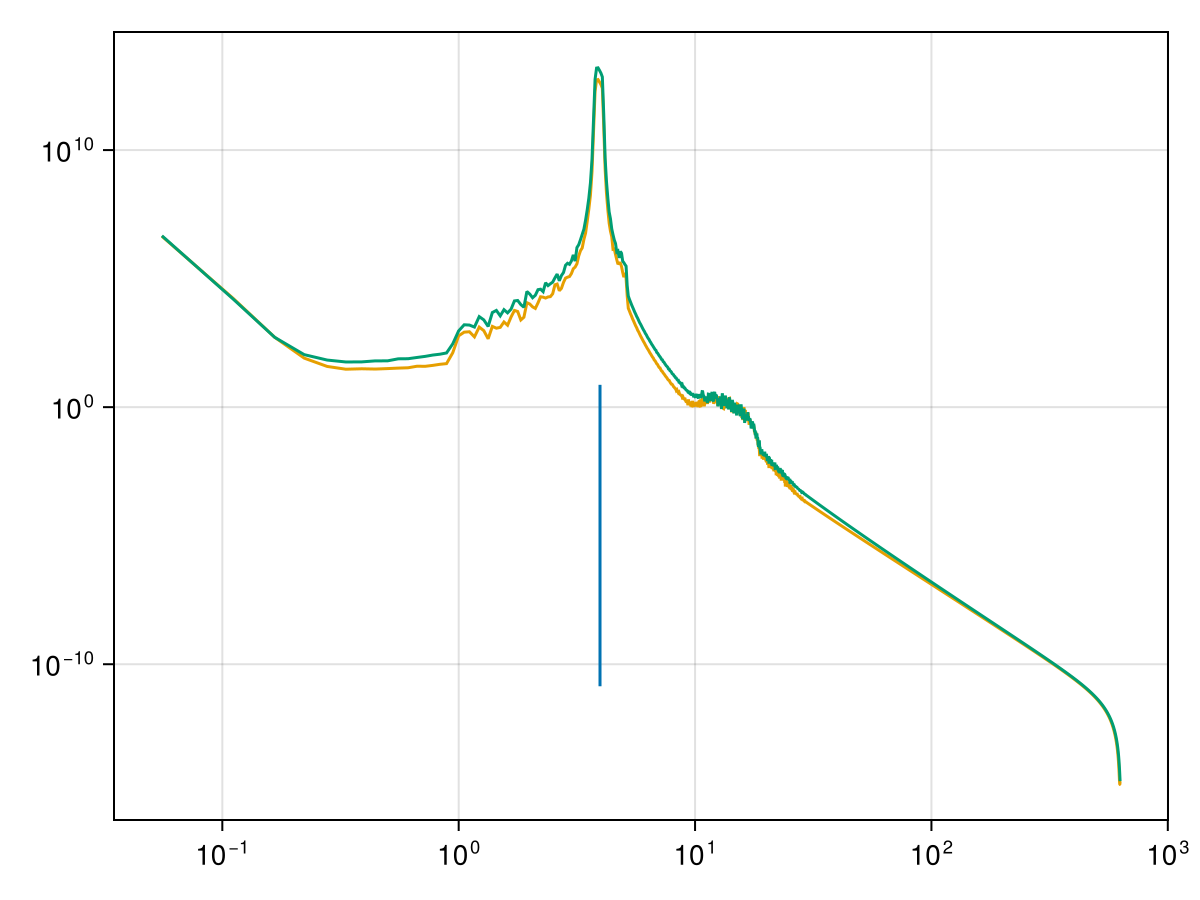

In [152]:
idx = 12
data = rotary_v[:,idx]
println(ω[N_half+2])

dispersion = sqrt(1 + (k_centers[idx])^2)

fig = Figure()
ax = Axis(fig[1,1], xscale=log10, yscale=log10)
lines!(ax, dispersion .+ 0*(-2:25), exp.(-25:2))
lines!(ax, ω[N_half+2:end], data[N_half+2:end])
lines!(ax, -ω[1:N_half], data[1:N_half])

fig

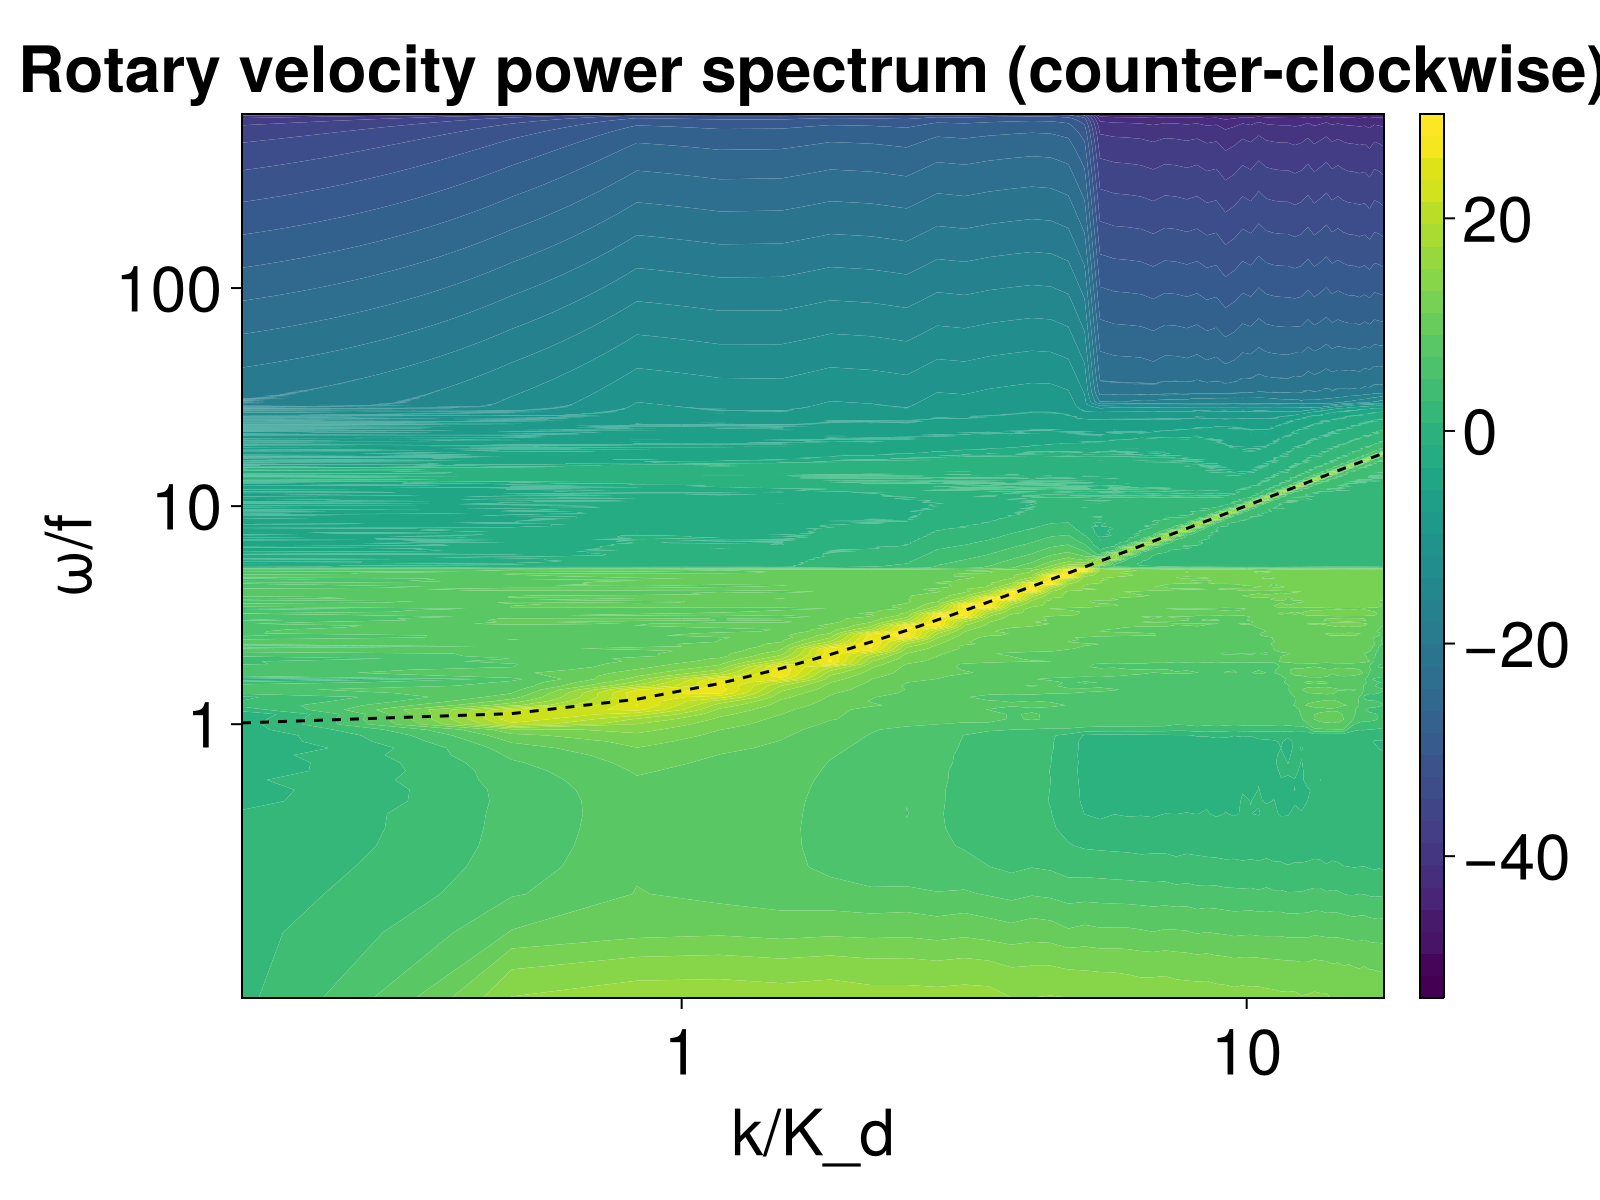

In [148]:
f = Figure(size=(800, 600), fontsize=32)
ax = Axis(f[1,1], title="Rotary velocity power spectrum (counter-clockwise)", 
    xlabel="k/K_d", ylabel="ω/f", 
    xscale=log10, yscale=log10,
    xticks = [1, 10], yticks=[1, 10, 100])

cmap = cgrad(:viridis, scale=log10)
hm = contourf!(ax, k_centers, ω[N_half+2:end], log.(rotary_v[N_half+2:end,:]'), levels=40)
lines!(ax, k_centers, sqrt.(1 .+ k_centers.^2), linestyle=:dash, color="black")
#contour!(ax, k_centers, ω[N_half+2:end],  rotary_v[N_half+2:end,:]')

cb = Colorbar(f[1,2], hm)

f

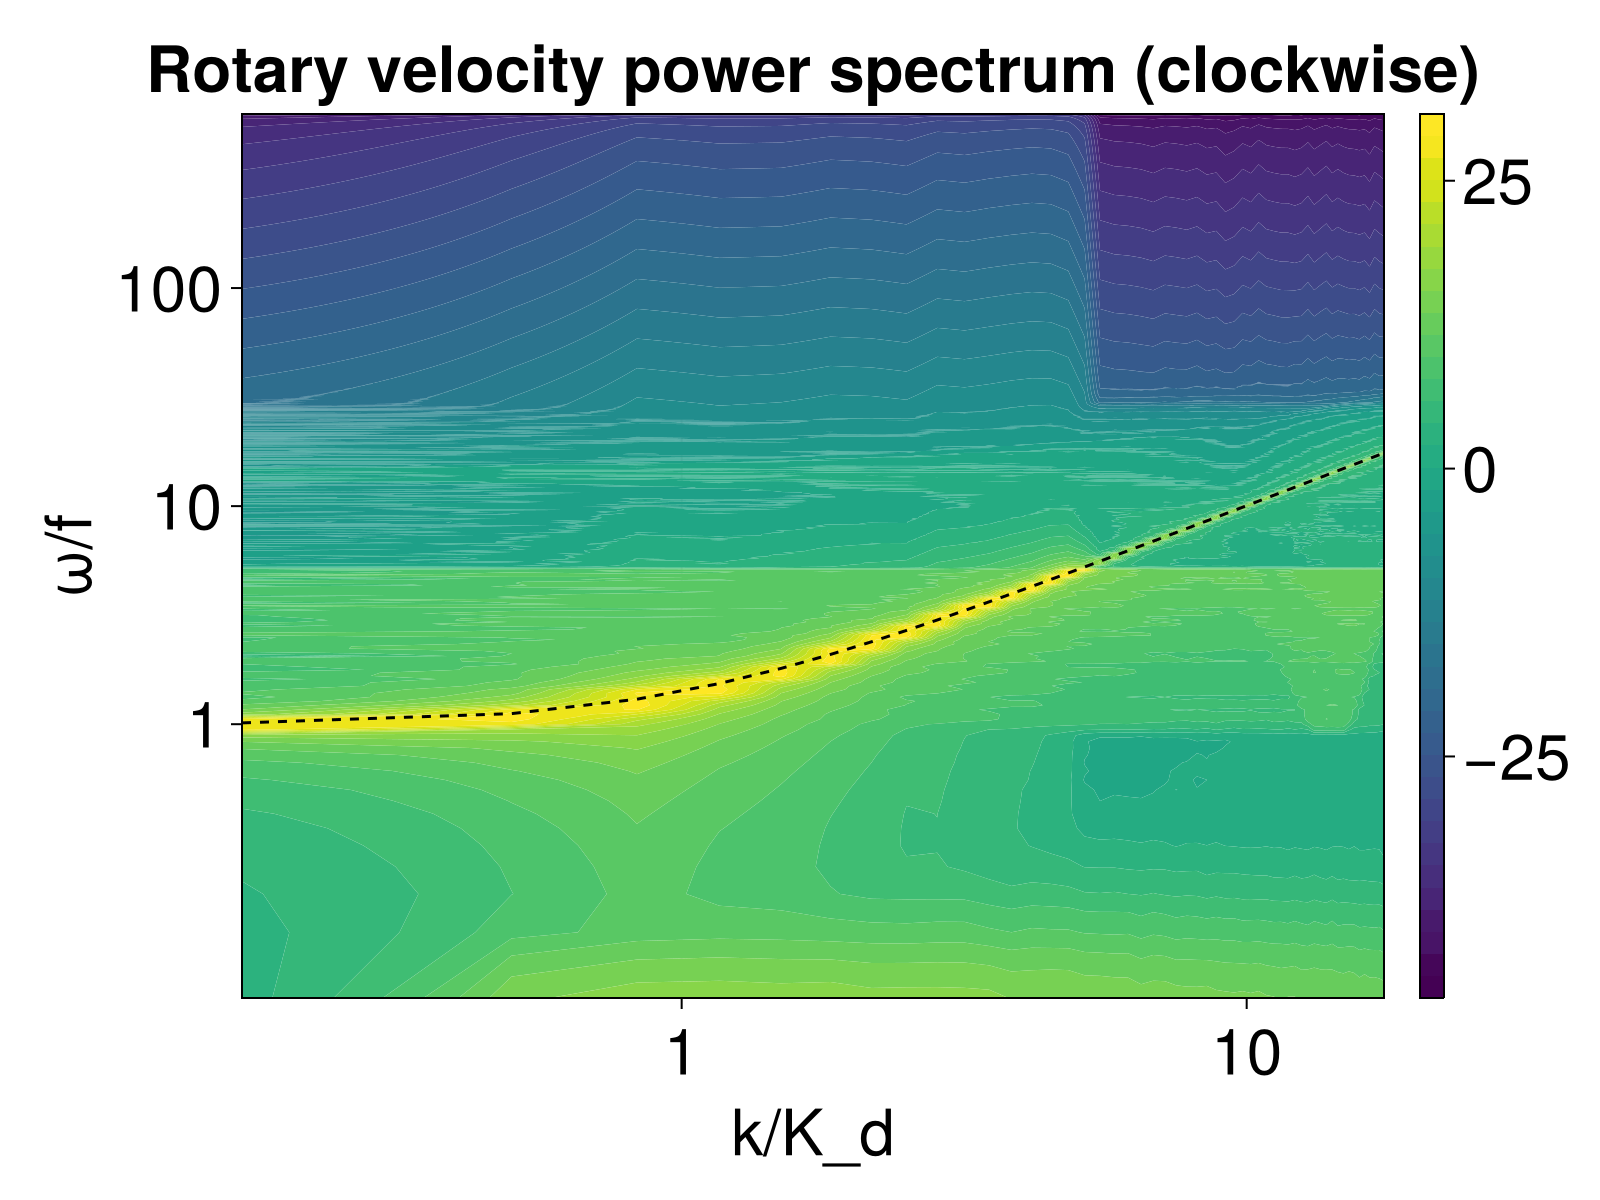

In [113]:
f = Figure(size=(800, 600), fontsize=32)
ax = Axis(f[1,1], title="Rotary velocity power spectrum (clockwise)", 
    xlabel="k/K_d", ylabel="ω/f", 
    xscale=log10, yscale=log10,
    xticks = [1, 10], yticks=[1, 10, 100])

cmap = cgrad(:viridis, scale=log10)
hm = contourf!(ax, k_centers, -ω[1:N_half], log.(rotary_v[1:N_half,:]'), levels=40)
lines!(ax, k_centers, sqrt.(1 .+ k_centers.^2), linestyle=:dash, color="black")
#contour!(ax, k_centers, ω[N_half+2:end],  rotary_v[N_half+2:end,:]')

cb = Colorbar(f[1,2], hm)

f

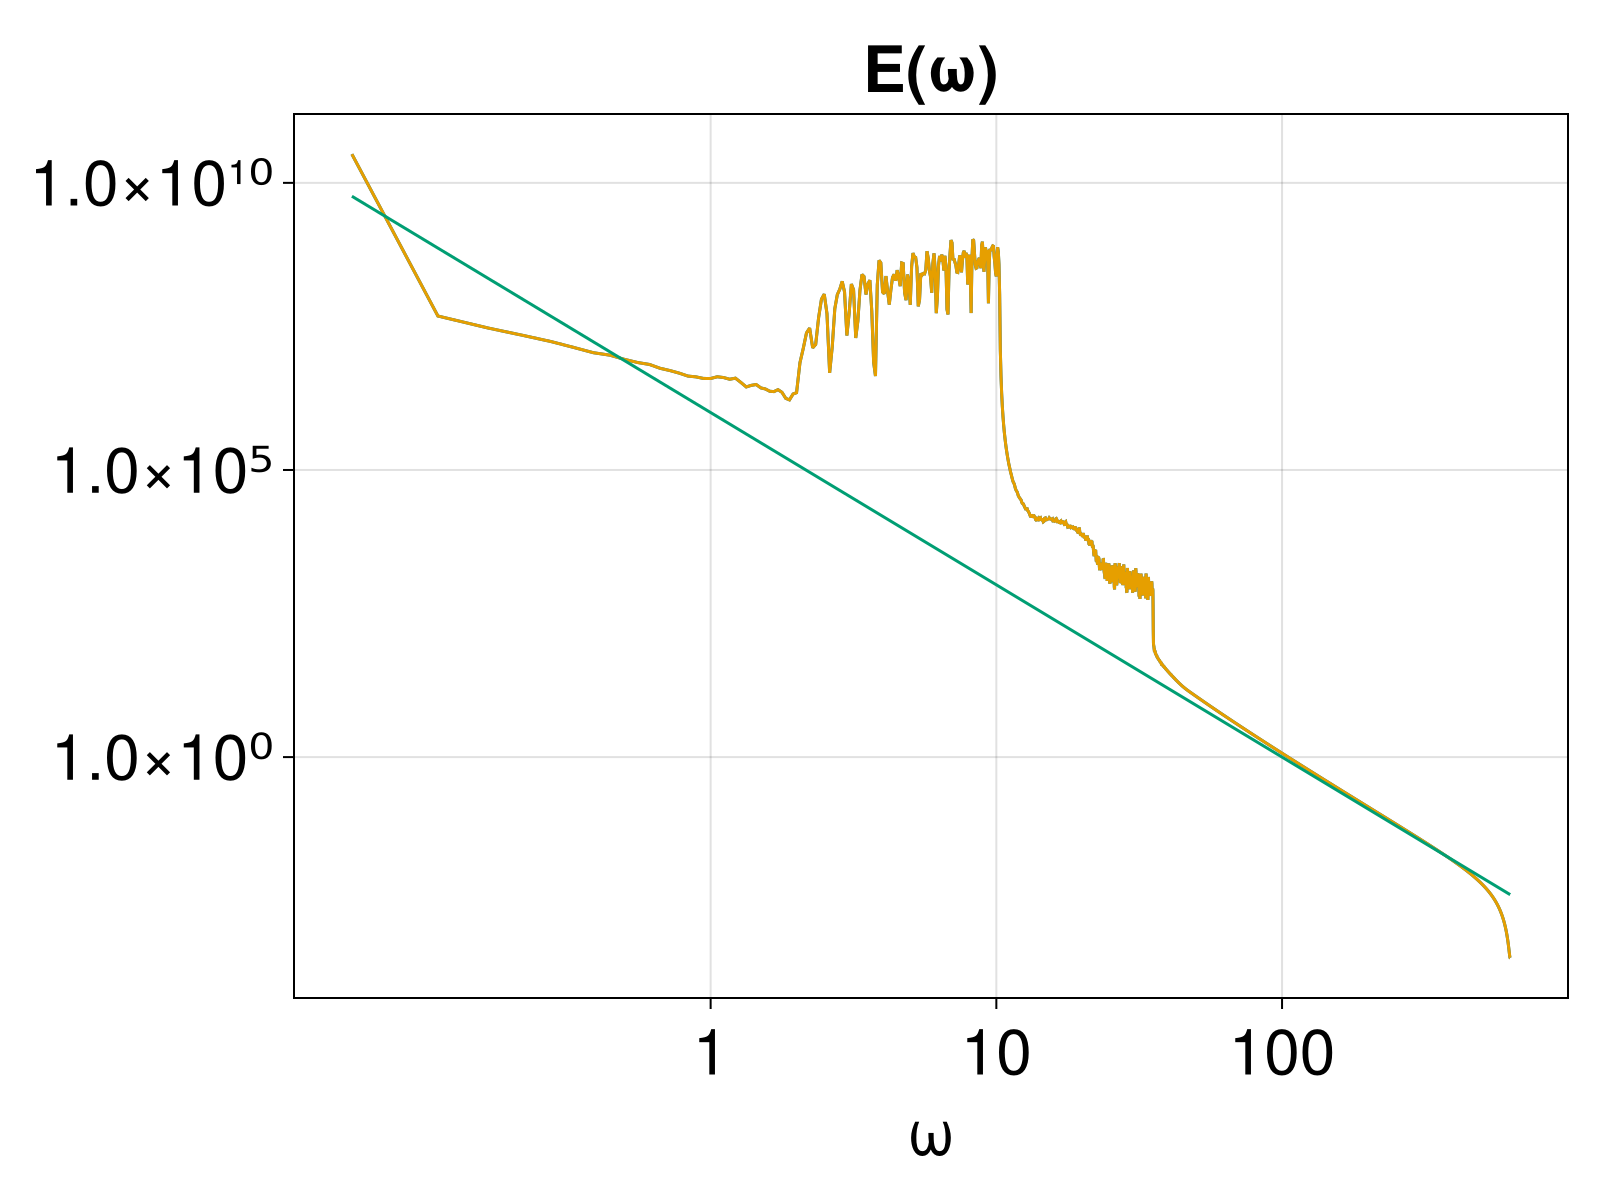

In [151]:
f = Figure(size=(800, 600), fontsize=32)
ax = Axis(f[1,1], title="E(ω)", 
    xlabel="ω", 
    xscale=log10, yscale=log10,
    xticks = [1, 10, 100], yticks=[1e-5, 1, 1e5, 1e10])

cmap = cgrad(:viridis, scale=log10)
lines!(ax, -ω[1:N_half], sum(energy[1:N_half,:], dims=2)[:])
lines!(ax, ω[N_half+2:end], sum(energy[N_half+2:end,:], dims=2)[:])
pos_ω = ω[N_half+2:end]
lines!(ax, pos_ω, 1e6*pos_ω.^(-3))
#hm = contourf!(ax, k_centers, -ω[1:N_half], log.(rotary_v[1:N_half,:]'), levels=40)
#lines!(ax, k_centers, sqrt.(1 .+ k_centers.^2), linestyle=:dash, color="black")
#contour!(ax, k_centers, ω[N_half+2:end],  rotary_v[N_half+2:end,:]')
#cb = Colorbar(f[1,2], hm)

f

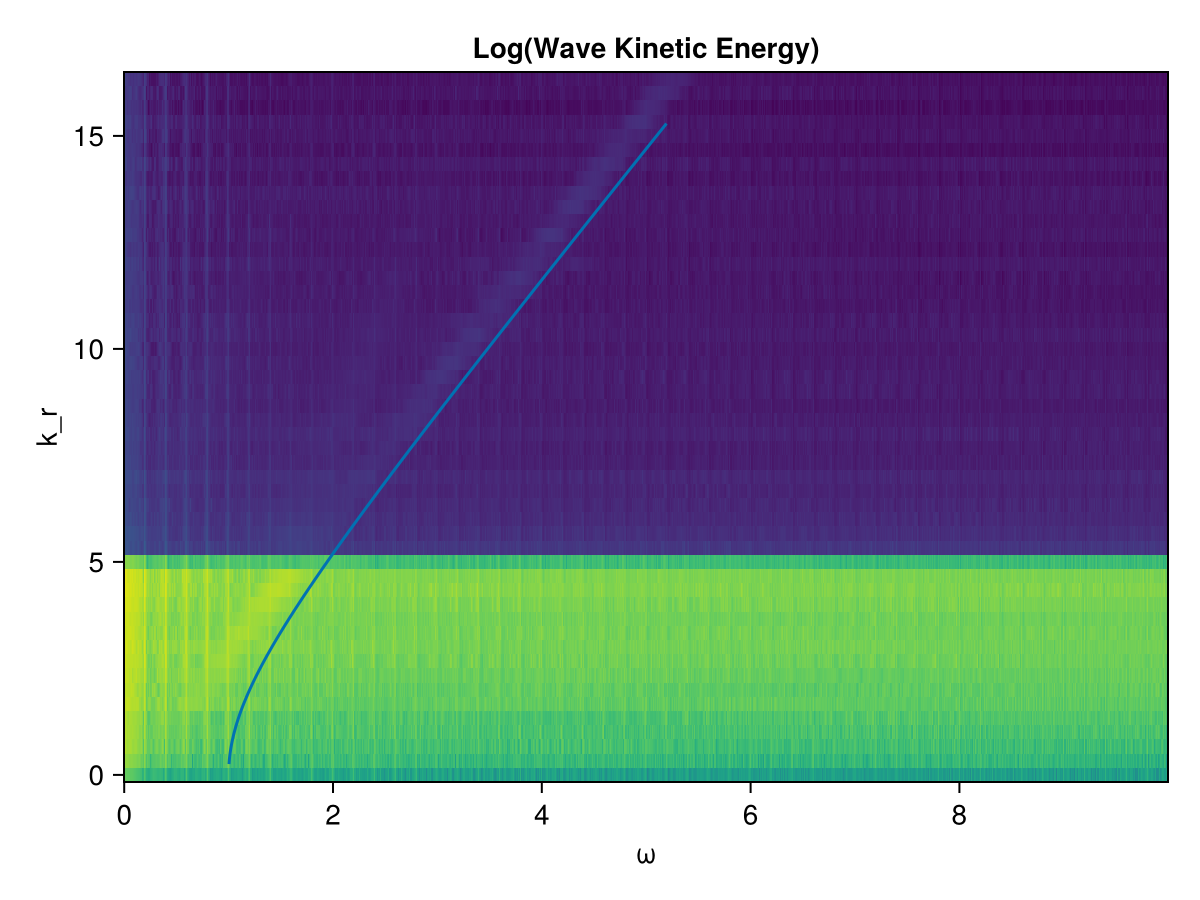

In [5]:
dt = base_file["snapshots/t/10"] - base_file["snapshots/t/0"]
nx = base_file["grid/nx"]
Lx = base_file["grid/Lx"]

wave_ke_abs_fourier = data_file["radial_energy"]
nω = size(wave_ke_abs_fourier, 1)
half_nω = Int(nω / 2)
nk = size(wave_ke_abs_fourier,2)

ks = fftfreq(nx, 2π/Lx * nx)
ωs = fftfreq(nω, 1/dt)
ωs_unidirectional = ωs[1:half_nω]
wave_ke_unidirectional = wave_ke_abs_fourier[1:half_nω,:] + wave_ke_abs_fourier[end:-1:half_nω+1,:]

f = Figure()
ax = Axis(f[1,1], title="Log(Wave Kinetic Energy)", xlabel="ω", ylabel="k_r")

heatmap!(ax, ωs_unidirectional, ks[1:nk], log.(wave_ke_unidirectional))

ω_min = findfirst(x -> x > 1, ωs_unidirectional)
ω_max = 1300#findfirst(x -> x >= sqrt((ks[end]/3)^2 + 1), ωs_unidirectional)
lines!(ax, ωs_unidirectional[ω_min:ω_max], 3*sqrt.(ωs_unidirectional[ω_min:ω_max].^2 .- 1))
f

In [154]:
grid.nkr

257

In [105]:
ωs_unidirectional[end].^2 < (ks[end]/3)^2 + 1

false

In [102]:
findfirst(x -> x >= sqrt((nk/3)^2 + 1), ωs_unidirectional)

In [104]:
3*sqrt.(ωs_unidirectional[ω_min:end].^2 .- 1)

2250-element Vector{Float64}:
  0.25473640711098594
  0.3704925454805238
  0.45817746031819667
  0.5318610850295311
  0.5967525551952989
  0.6554683670732013
  0.7095433165588021
  0.7599687004417293
  0.8074285745297101
  0.8524184125306299
  0.8953106538032267
  0.9363935889058896
  0.975895747307419
  ⋮
 29.704952012068638
 29.717008207463714
 29.729064353513866
 29.74112045027911
 29.753176497819354
 29.765232496194404
 29.777288445463995
 29.78934434568773
 29.801400196925137
 29.813455999235646
 29.82551175267859
 29.83756745731319

In [28]:
 base_file["grid/nx"]

512

In [29]:
plot(

512-element Frequencies{Float64}:
  0.0
  0.3333333333333333
  0.6666666666666666
  1.0
  1.3333333333333333
  1.6666666666666665
  2.0
  2.333333333333333
  2.6666666666666665
  3.0
  3.333333333333333
  3.6666666666666665
  4.0
  ⋮
 -4.0
 -3.6666666666666665
 -3.333333333333333
 -3.0
 -2.6666666666666665
 -2.333333333333333
 -2.0
 -1.6666666666666665
 -1.3333333333333333
 -1.0
 -0.6666666666666666
 -0.3333333333333333

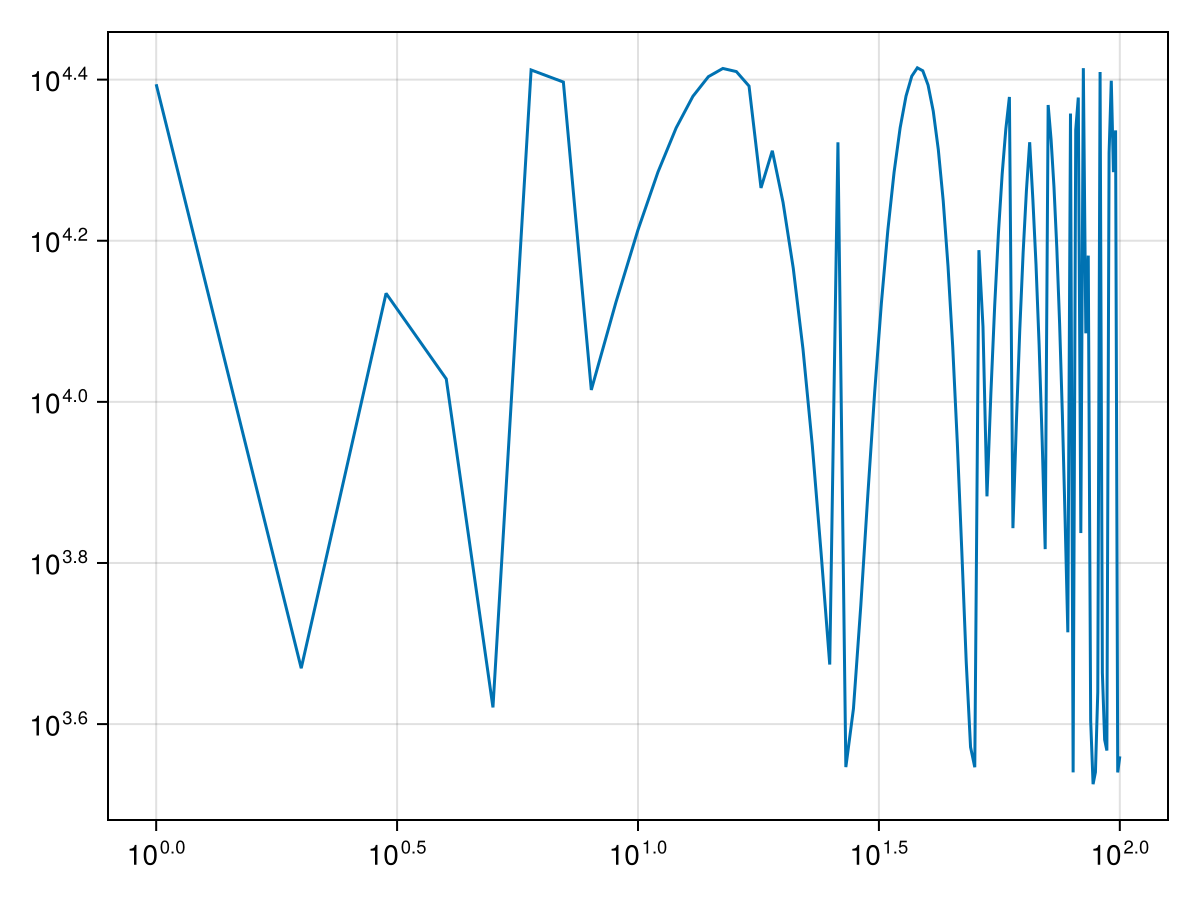

In [147]:
f = Figure()
ax = Axis(f[1,1], xscale=log10, yscale=log10)
lines!(ax, data_file["8/omega"][1:100,4])
f

In [126]:
data_file["9/omega"]

5002×29 Matrix{Float64}:
 24957.8   28757.7   11688.8  14943.4   …  26672.1   24935.4   27025.7
 26415.2   28302.6   15162.3  18558.7      25624.7   26567.4   26250.1
 26964.9   26854.8   18644.1  21863.6      23606.0   27234.7   24568.4
 26562.3   24532.1   21838.9  24559.4      20798.4   26880.6   22118.6
 25239.5   21524.0   24475.5  26402.4      17455.7   25535.3   19101.5
  5276.98  24994.9   24885.5  15387.5   …   2978.38  10933.2   22738.3
 15683.2    6040.45  12267.8   7666.83     25077.6    3197.38   4958.57
 21488.4   20843.9   12831.0   3164.32     14937.4   25458.1   18497.0
 18460.5   17331.8   16353.5   3115.02     18463.6   26797.0   15130.7
 15160.9   13722.1   19787.5   4154.13     21661.1   27149.2   11769.0
 11854.6   10310.0   22841.0   6187.95  …  24240.9   26484.3    8686.8
  8807.24   7374.72  25254.6   9032.76     25970.1   24858.6    6136.25
  6263.76   5156.12  26823.1  12431.4      26692.7   22409.7    4325.8
     ⋮                                  ⋱         